analysis with dirty comments, mixed styles and languages

In [155]:
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [156]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Anechka\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Anechka\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [157]:
print(nltk.data.find('tokenizers/punkt'))
print(nltk.data.find('corpora/stopwords'))

C:\Users\Anechka\AppData\Roaming\nltk_data\tokenizers\punkt
C:\Users\Anechka\AppData\Roaming\nltk_data\corpora\stopwords


In [158]:
df_path = 'data/raw/df_common.csv'
df = pd.read_csv(df_path, index_col=0)
df.head()

C:\Temp\ipykernel_7196\3654889665.py:2: DtypeWarning: Columns (4,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(df_path, index_col=0)


,raw_text_id,dataset_id,source_platform,nickname,is_verified,text_raw,is_toxic,toxicity_type
0,0,0,"2ch, pikabu",NaN,1,"Верблюдов-то за что? Дебилы, бл...\n",1.0,NaN
1,1,0,"2ch, pikabu",NaN,1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0,NaN
2,2,0,"2ch, pikabu",NaN,1,Собаке - собачья смерть\n,1.0,NaN
3,3,0,"2ch, pikabu",NaN,1,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0,NaN
4,4,0,"2ch, pikabu",NaN,1,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0,NaN


In [159]:
df.shape

(469967, 8)

In [160]:
# Check dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 469967 entries, 0 to 469966
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   raw_text_id      469967 non-null  int64  
 1   dataset_id       469967 non-null  int64  
 2   source_platform  469967 non-null  object 
 3   nickname         1964 non-null    object 
 4   is_verified      469967 non-null  int64  
 5   text_raw         469967 non-null  object 
 6   is_toxic         345381 non-null  float64
 7   toxicity_type    372869 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 32.3+ MB


Found object dtype regardless of hard-typisation rules were implemented earlier. 

In [161]:
# Remove leading/trailing whitespaces
df['text_raw'] = df['text_raw'].astype('string')
df['toxicity_type'] = df['toxicity_type'].astype('string')
df['nickname'] = df['nickname'].astype('string')
df['source_platform'] = df['source_platform'].astype('string')

In [162]:
df.shape

(469967, 8)

In [163]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 469967 entries, 0 to 469966
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   raw_text_id      469967 non-null  int64  
 1   dataset_id       469967 non-null  int64  
 2   source_platform  469967 non-null  string 
 3   nickname         1964 non-null    string 
 4   is_verified      469967 non-null  int64  
 5   text_raw         469967 non-null  string 
 6   is_toxic         345381 non-null  float64
 7   toxicity_type    372869 non-null  string 
dtypes: float64(1), int64(3), string(4)
memory usage: 32.3 MB


In [164]:
# df.to_csv('data/raw/df_common.csv')

In [165]:
df.shape

(469967, 8)

In [166]:
# Check duplicates based on text
duplicate_count = df.duplicated(subset=['text_raw']).sum()
print(f"Duplicate texts: {duplicate_count}")
df.drop_duplicates(subset=['text_raw'], inplace=True)

Duplicate texts: 14416


## Basic stats 

In [167]:
print(f"Total records: {len(df)}")
print("Columns:", df.columns.tolist())

Total records: 455551
Columns: ['raw_text_id', 'dataset_id', 'source_platform', 'nickname', 'is_verified', 'text_raw', 'is_toxic', 'toxicity_type']


In [168]:
# Count toxic vs non-toxic
print(df['is_toxic'].value_counts())

is_toxic
0.0    259428
1.0     71541
Name: count, dtype: int64


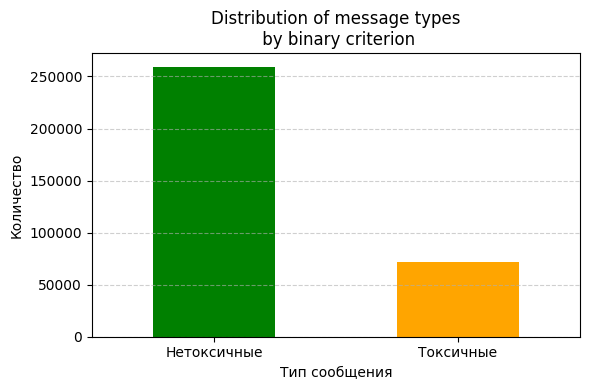

In [190]:
import matplotlib.pyplot as plt

counts = df['is_toxic'].value_counts()

# Построение столбчатой диаграммы
plt.figure(figsize=(6, 4))
counts.plot(kind='bar', color=['green', 'orange'])
plt.title('Distribution of message types\n by binary criterion')
plt.xlabel('Тип сообщения')
plt.ylabel('Количество')
plt.xticks([0, 1], ['Нетоксичные', 'Токсичные'], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Единая стандартизация меток мультикласса на основе информации из датасетов:

In [170]:
toxicity_types_map = {
    'SENSITIVE':       'Чувствительная тема',     # обсуждение тем, которые “flammable” и могут навредить репутации компании или участника диалога. :contentReference[oaicite:1]{index=1}
    'INSULT':          'Оскорбление',                                       # прямое оскорбление человека или группы.
    'INAPPROPRIATE':   'Неуместное высказывание',                            # сообщение может быть неявно токсичным или не содержит конкретных оскорблений, но всё-таки считается неприемлемым (например, затрагивает чувствительные темы, нарушает тон/контекст). :contentReference[oaicite:2]{index=2}
    'THREAT':          'Угроза',                                             # угрожающее высказывание или намерение нанести вред.
    'OBSCENITY':       'Непристойность / вульгарность'                         # использование грубой лексики, матерщины. 
}

In [171]:
df[df['toxicity_type']=='NORMAL']['is_toxic'] = 0

C:\Temp\ipykernel_7196\1239108764.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df['toxicity_type']=='NORMAL']['is_toxic'] = 0


In [ ]:
# en -> ru
df['toxicity_type_ru'] = df['toxicity_type'].map(toxicity_types_map)
df['toxicity_type_ru'] = df['toxicity_type_ru'].fillna('Не указано')

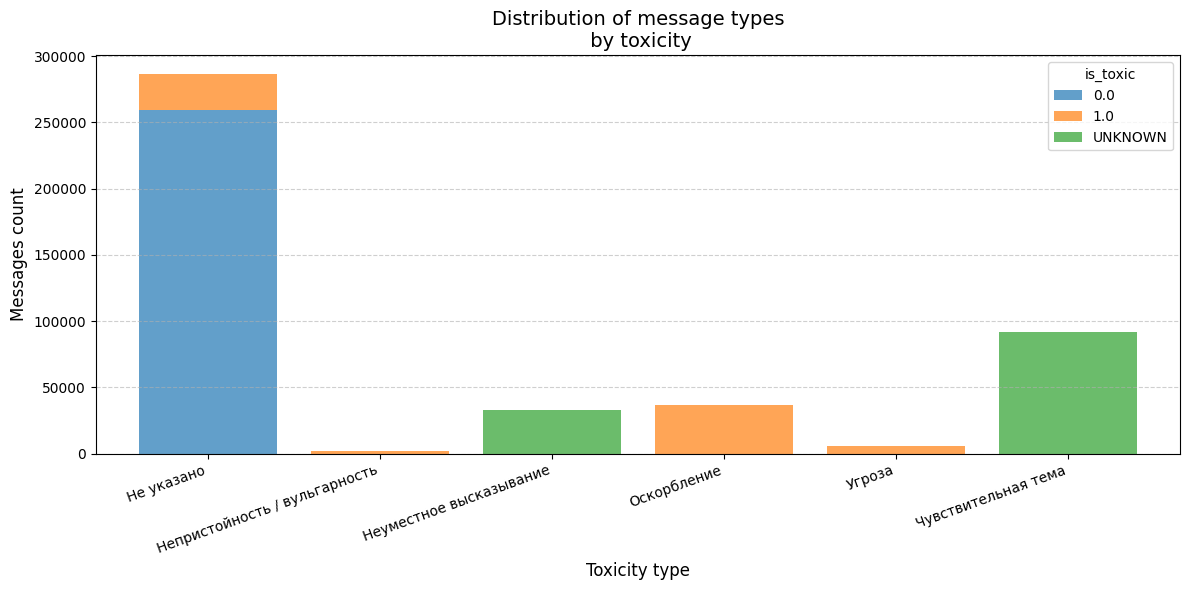

In [188]:
df_plot = df.copy()
df_plot['is_toxic'] = df_plot['is_toxic'].fillna('UNKNOWN')
df_plot['toxicity_type_ru'] = df_plot['toxicity_type_ru'].fillna('Не указано')
df_plot['is_toxic'] = df_plot['is_toxic'].astype(str)
df_plot['toxicity_type_ru'] = df_plot['toxicity_type_ru'].astype(str)

toxicity_counts = df_plot.groupby(['toxicity_type_ru', 'is_toxic']).size().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(12, 6))
# toxicity_counts.plot(kind='bar', stacked=True, ax=ax, width=0.8, alpha=0.7, logy=True) 
toxicity_counts.plot(kind='bar', stacked=True, ax=ax, width=0.8, alpha=0.7) 

ax.set_xticks(range(len(toxicity_counts.index)))
ax.set_xticklabels(toxicity_counts.index, rotation=20, ha='right')

plt.title('Distribution of message types\n by toxicity', fontsize=14)
plt.xlabel('Toxicity type', fontsize=12)
plt.ylabel('Messages count', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(title='is_toxic')
plt.tight_layout()
plt.show()


In [174]:
set(df['toxicity_type'].values)

{<NA>, 'INAPPROPRIATE', 'INSULT', 'NORMAL', 'OBSCENITY', 'SENSITIVE', 'THREAT'}

In [175]:
# calc char_len, word_len: 
df['char_len'] = df['text_raw'].apply(len)
df['word_len'] = df['text_raw'].apply(lambda x: len(x.split()))

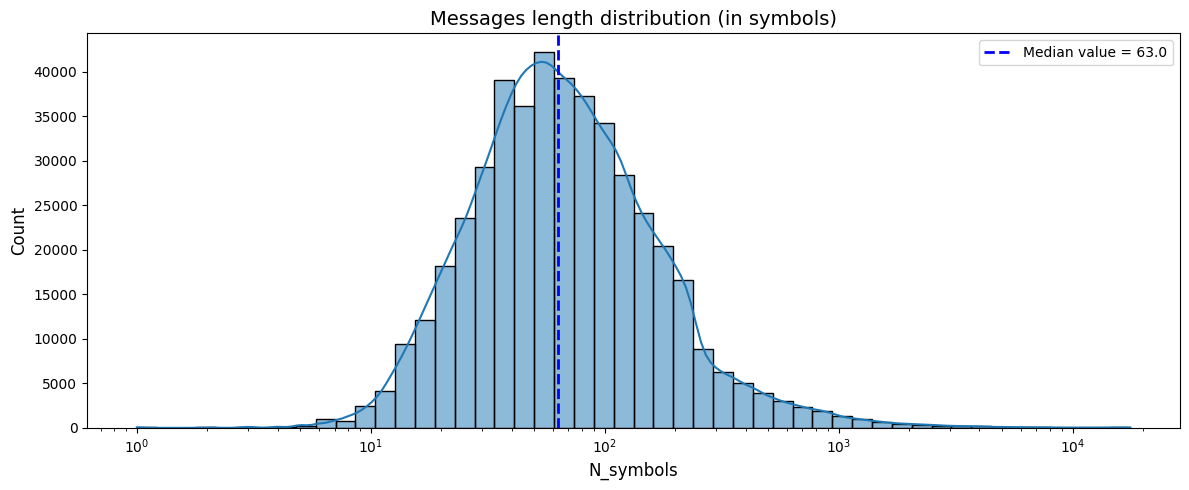

In [184]:

median_char = df['char_len'].median()

plt.figure(figsize=(12, 5))
sns.histplot(df['char_len'], bins=50, kde=True, log_scale=True)

plt.axvline(median_char, color='blue', linestyle='--', linewidth=2, label=f'Median value = {median_char:.1f}')

plt.title('Messages length distribution (in symbols)', fontsize=14)
plt.xlabel('N_symbols', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()


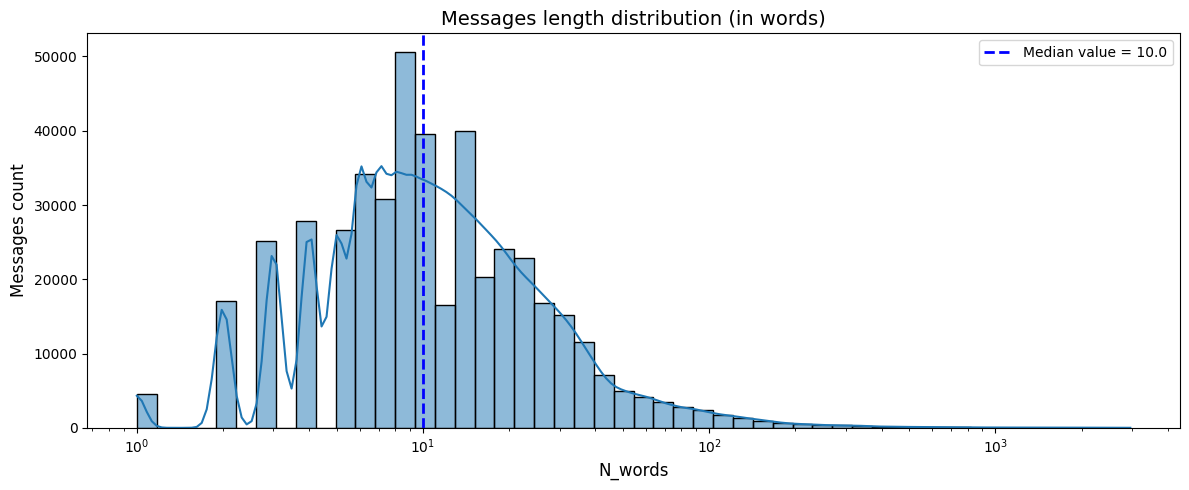

In [186]:
median_val = df['word_len'].median()

plt.figure(figsize=(12, 5))
sns.histplot(df['word_len'], bins=50, kde=True, log_scale=True)

plt.axvline(median_val, color='blue', linestyle='--', linewidth=2, label=f'Median value = {median_val:.1f}')

plt.title('Messages length distribution (in words)', fontsize=14)
plt.xlabel('N_words', fontsize=12)
plt.ylabel('Messages count', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()


In [178]:
# # Compare toxic vs non-toxic message lengths
# plt.figure(figsize=(10,5))
# sns.boxplot(x='is_toxic', y='word_len', data=df)
# plt.title('Text Length Distribution by Toxicity')
# plt.xlabel('Is Toxic')
# plt.ylabel('Word Count')
# plt.show()

In [179]:
df['source_platform'].value_counts()

source_platform
ok.ru                                    248283
2ch.hk, Pikabu.ru, otveti.mail.ru        124582
2ch, vk                                   62012
2ch, pikabu                               14412
YouTube                                    1964
Social Media, TV-Scripts (South Park)      1455
лентач                                      988
медуза                                      942
дождь                                       913
Name: count, dtype: Int64

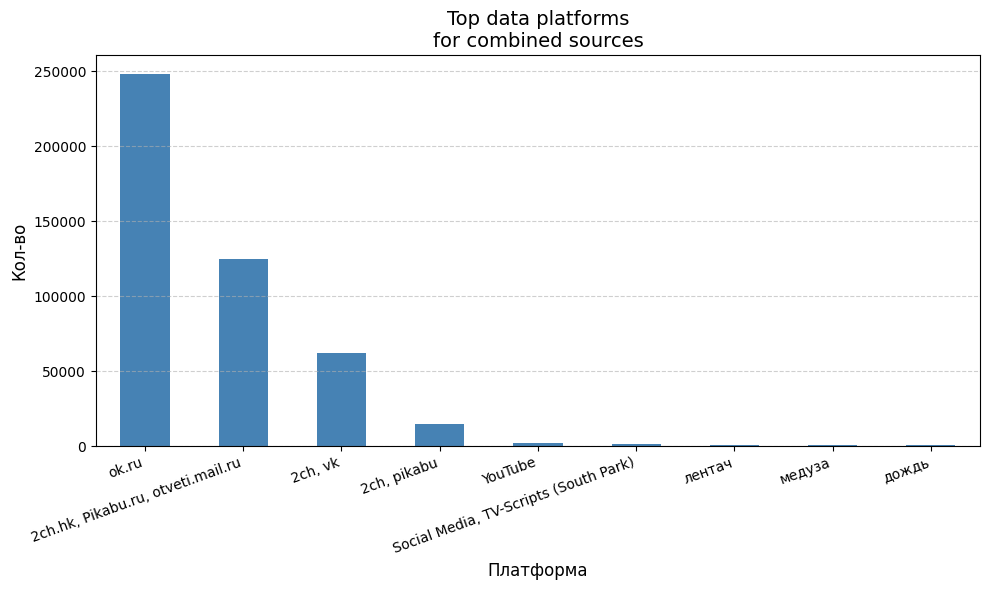

In [180]:
plt.figure(figsize=(10, 6))
df['source_platform'].value_counts().plot(kind='bar', color='steelblue')

plt.title('Top data platforms\nfor combined sources', fontsize=14)
plt.xlabel('Платформа', fontsize=12)
plt.ylabel('Кол-во', fontsize=12)

plt.xticks(rotation=20, ha='right')

# y grid: 
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()



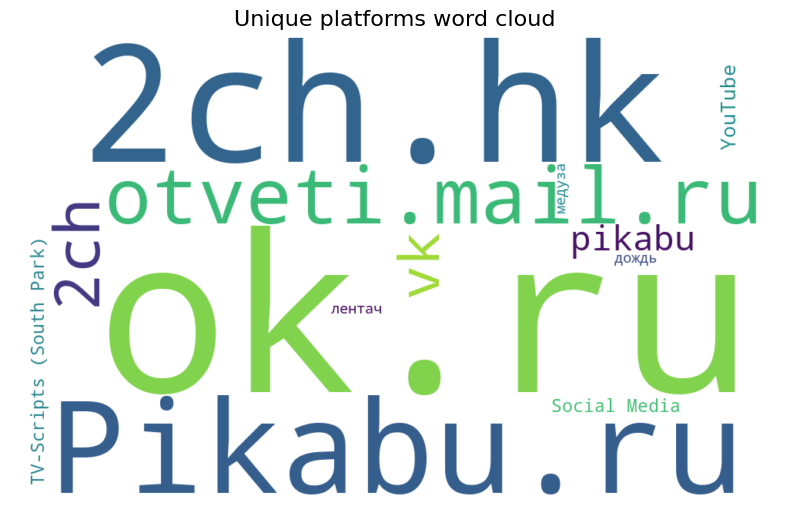

In [181]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

all_sources = []

for item in df['source_platform'].dropna():
    parts = [p.strip() for p in item.split(',')]
    all_sources.extend(parts)

freq_dict = dict(Counter(all_sources))

wordcloud = WordCloud(
    width=1000,
    height=600,
    background_color='white',
    colormap='viridis',
    prefer_horizontal=0.6,
    relative_scaling=0.5  
).generate_from_frequencies(freq_dict)

plt.figure(figsize=(8, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Unique platforms word cloud', fontsize=16)
plt.tight_layout()
plt.show()


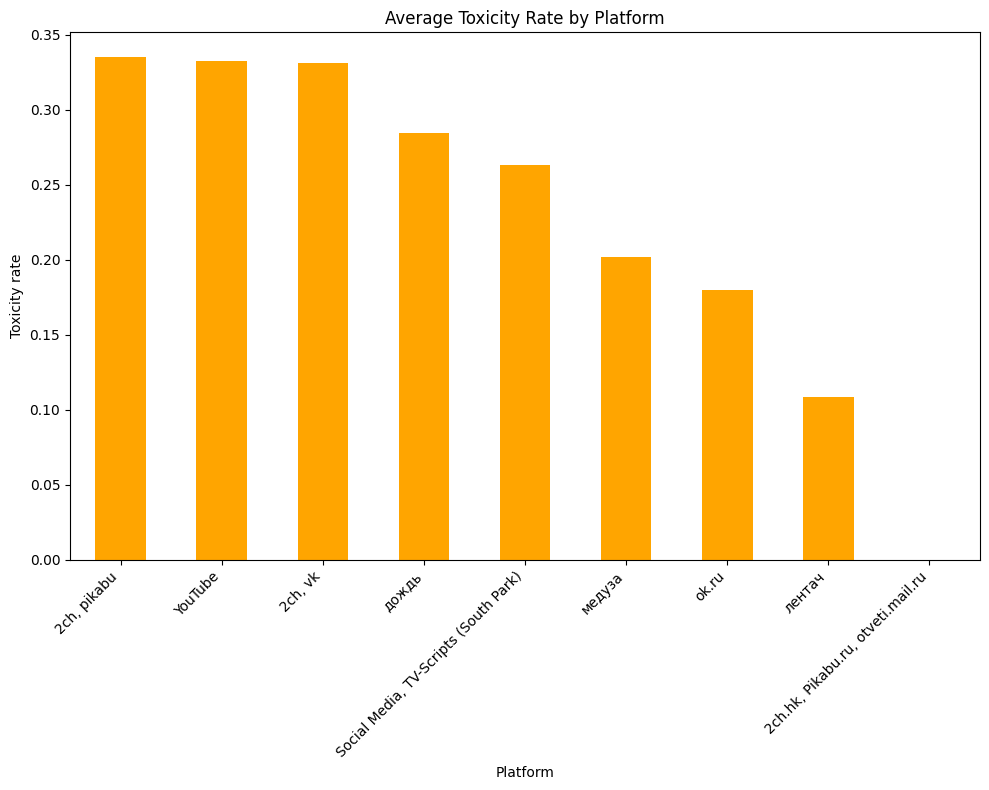

In [182]:
# ----- Compute average toxicity rate per platform -----
tox_by_platform = df.groupby('source_platform')['is_toxic'].mean().sort_values(ascending=False)

# ----- Plot top 10 platforms with highest toxicity -----
plt.figure(figsize=(10, 8))
ax = tox_by_platform.head(10).plot(kind='bar', color='orange')

# Rotate x-axis labels for better readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.title('Average Toxicity Rate by Platform')
plt.ylabel('Toxicity rate')
plt.xlabel('Platform')
plt.tight_layout()
plt.show()

